# Canonical Examples 

We will introduce some canonical examples, and show when and why those are going wrong in an MBO scenario. 

In [2]:
library(mvtnorm)
library(ggplot2)
library(gridExtra)
library(mlrMBO)
library(data.table)
library(BBmisc)
library(iml)

library("rpart.plot")
library("rattle")
library("RColorBrewer")

## Introduce the Canonical Examples

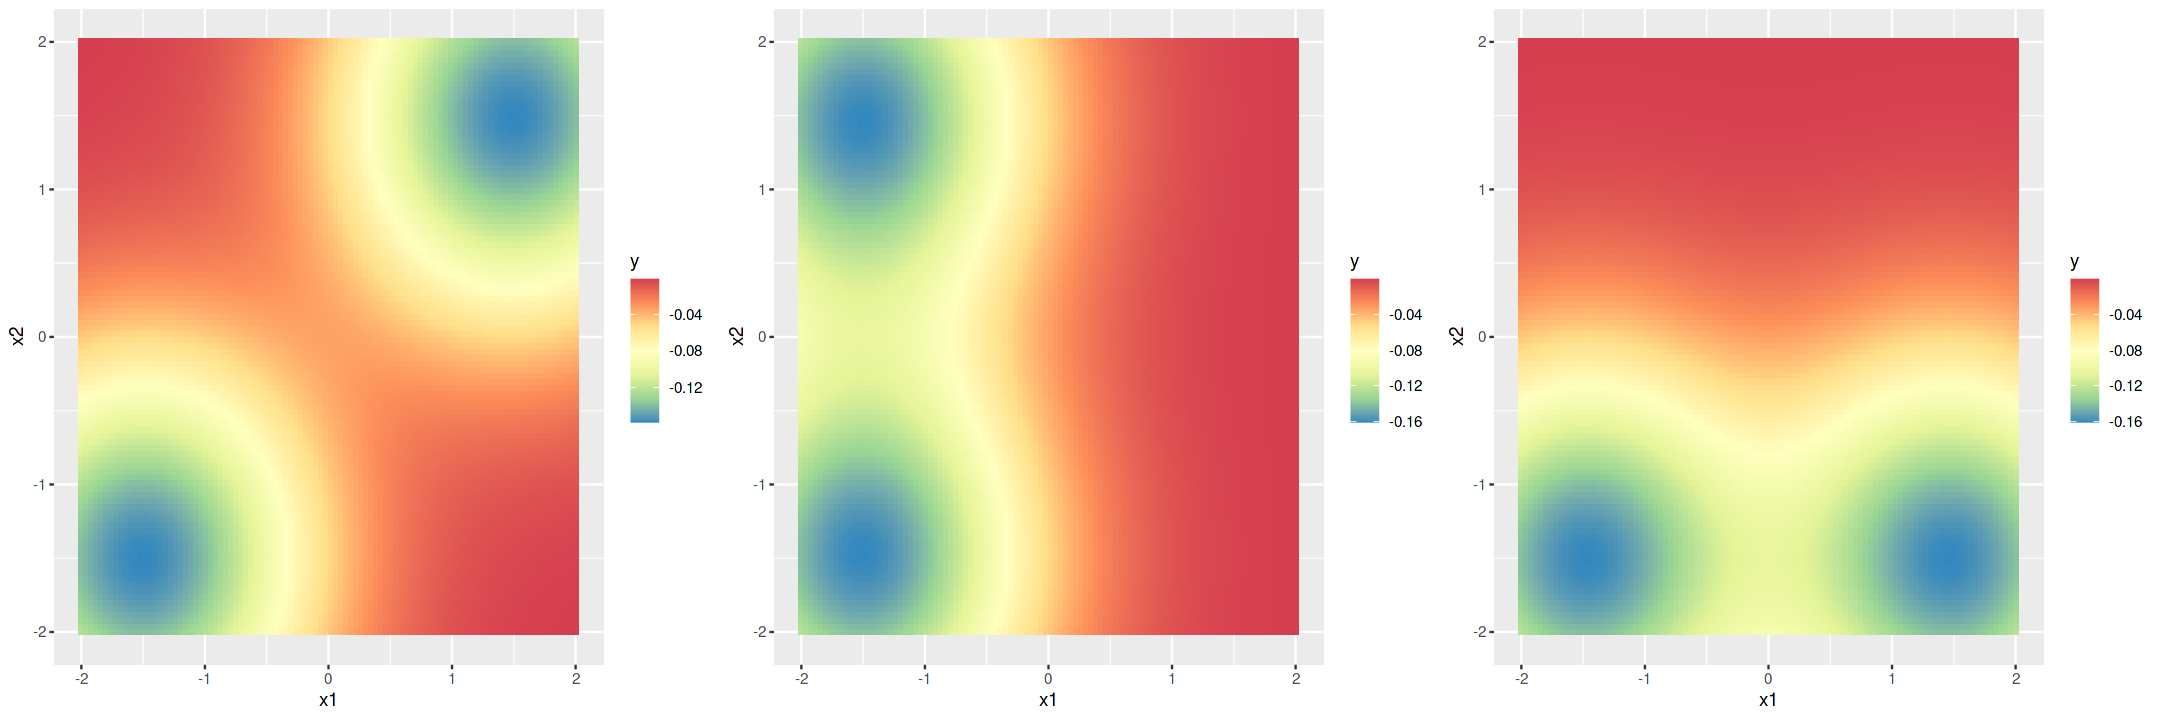

In [5]:
options(repr.plot.width=18, repr.plot.height=6)

p1 = plot_function(obj1)
p2 = plot_function(obj2)
p3 = plot_function(obj3)

grid.arrange(p1, p2, p3, ncol = 3)

## Create mlrMBO Runs

In [198]:
createMBOrun = function(fun, max.evals, lambda, store_path, init_size = NULL) {
    
    set.seed(1234)
    
    ps = getParamSet(fun)

    ctrl = makeMBOControl(store.model.at = seq_len(max.evals))
    ctrl = setMBOControlTermination(ctrl, max.evals = max.evals)
    ctrl = setMBOControlInfill(ctrl, makeMBOInfillCritCB(cb.lambda = lambda))

    if (is.null(init_size))
        init_size = 4 * getParamLengths(ps)
        
    des = generateDesign(n = init_size, par.set = ps, fun = lhs::randomLHS)
    
    res = mbo(fun, design = des, control = ctrl, show.info = FALSE)
    
    saveRDS(res, store_path)
}

In [199]:
createMBOrun(fun = obj1, max.evals = 50, lambda = 3, store_path = "synthetic/mlrmbo_run_XOR_2.rds")
createMBOrun(fun = obj2, max.evals = 50, lambda = 3, store_path = "synthetic/mlrmbo_run_VERTICAL_2.rds")
createMBOrun(fun = obj3, max.evals = 50, lambda = 3, store_path = "synthetic/mlrmbo_run_HORIZONTAL_2.rds")

In [200]:
runs = list(XOR = readRDS("synthetic/mlrmbo_run_XOR_2.rds"),
            VERTICAL = readRDS("synthetic/mlrmbo_run_VERTICAL_2.rds"), 
            HORIZONTAL = readRDS("synthetic//mlrmbo_run_HORIZONTAL_2.rds"))

In [201]:
opdf = lapply(seq_along(runs), function(x) {
    df = as.data.table(as.data.frame(runs[[x]]$opt.path))
    df$type = names(runs)[x]
    return(df)
    }
)

opdf = do.call(rbind, opdf)
opdf$type = as.factor(opdf$type)

In [202]:
models = lapply(seq_along(runs), function(i) {
    df = as.data.table(as.data.frame(runs[[i]]$opt.path))
    models = runs[[i]]$models
    model = models[[length(models)]]
    if (11 %in% df$cb.lambda)
        model = models[[1]]
    return(model)
    })

names(models) = names(runs)

In [203]:
preds = lapply(seq_along(models), function(i) {
    ps = getParamSet(obj[[i]])
    x1 <- seq(from = ps$pars$x$lower[1], to = ps$pars$x$upper[1], length.out = 100)
    x2 <- seq(from = ps$pars$x$lower[2], to = ps$pars$x$upper[2], length.out = 100)
    gg <- expand.grid(x1 = x1, x2 = x2)
    gg$y = apply(gg, 1, obj[[i]])

    pred = predict(models[[i]], newdata = gg)$data
    pred$residual = pred$response - gg$y
    pred$abs_error = abs(pred$response - gg$y)
    pred$type = names(models)[i]
    cbind(gg, pred)
    }
)
preds = do.call(rbind, preds)

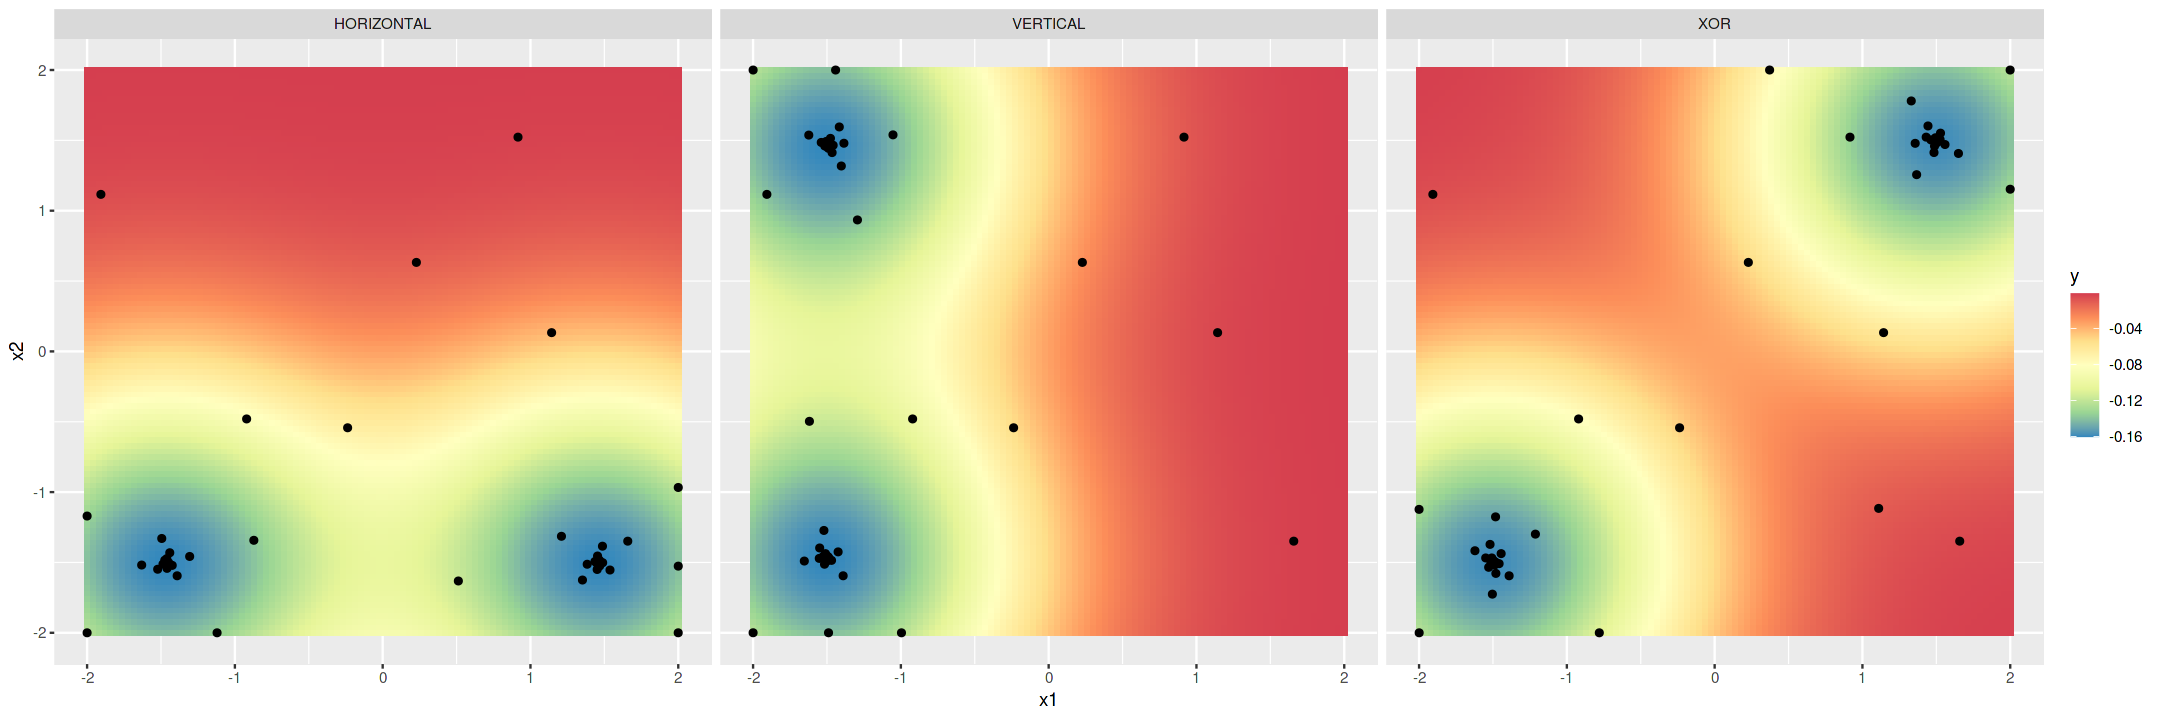

In [204]:
p2 = ggplot() + geom_tile(data = preds, aes(x = x1, y = x2, fill = y))
p2 = p2 + geom_point(data = opdf, aes(x = x1, y = x2)) 
p2 = p2 + scale_fill_distiller(palette = "Spectral")

p2 + facet_grid(. ~ type)

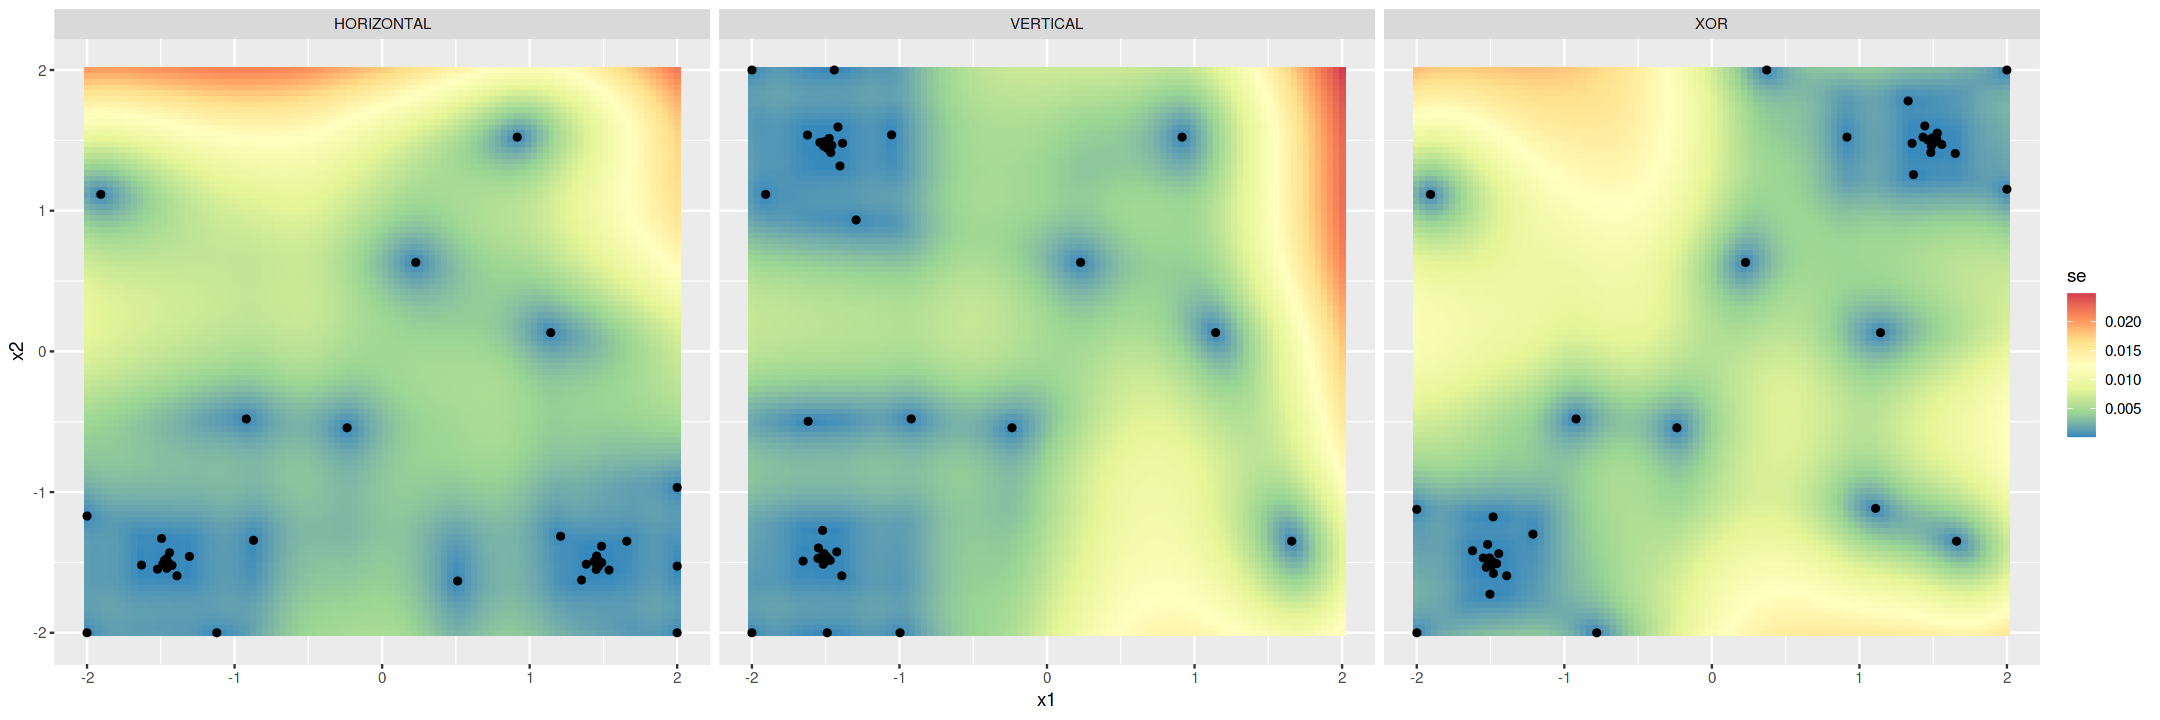

In [205]:
p2 = ggplot() + geom_tile(data = preds, aes(x = x1, y = x2, fill = se))
p2 = p2 + geom_point(data = opdf, aes(x = x1, y = x2)) 
p2 = p2 + scale_fill_distiller(palette = "Spectral")
p2 + facet_grid(. ~ type)

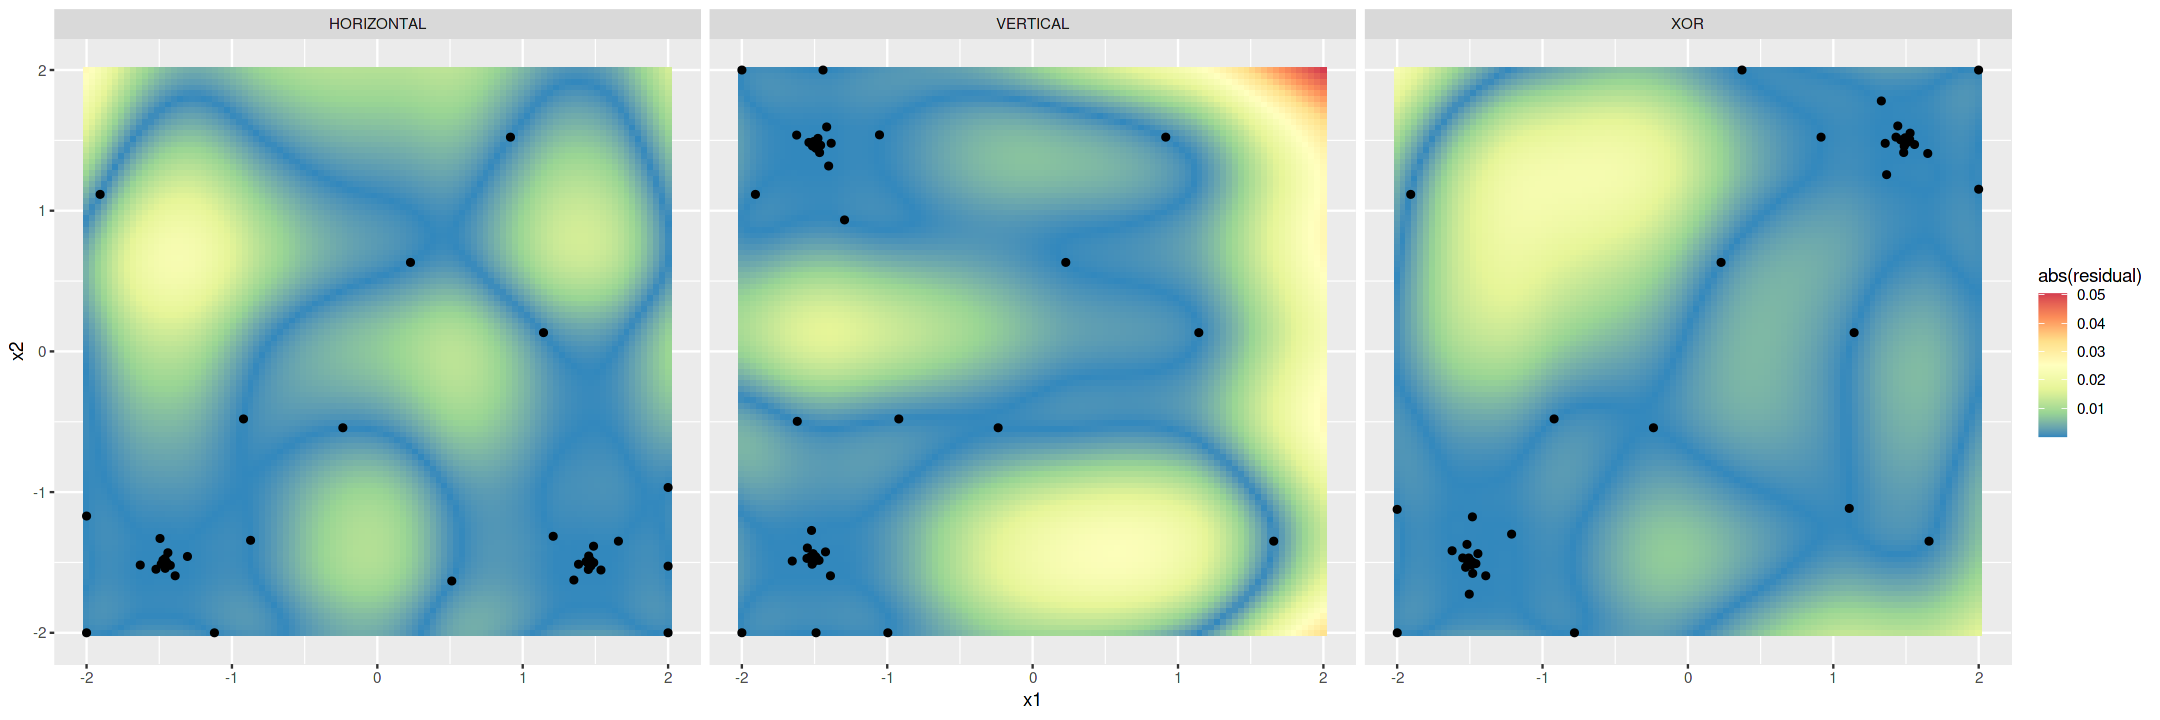

In [206]:
p2 = ggplot() + geom_tile(data = preds, aes(x = x1, y = x2, fill = abs(residual)))
p2 = p2 + geom_point(data = opdf, aes(x = x1, y = x2)) 
p2 = p2 + scale_fill_distiller(palette = "Spectral")
p2 + facet_grid(. ~ type)

## Investigation of Partial Dependence Plots

In [207]:
gtPDP = function(obj, feature, opdf_sub) {
        
    mymodel = makeS3Obj("mymodel", fun = function(data) return(apply(data[, c("x1", "x2")], 1, obj)))
                        
    predict.mymodel = function(object, newdata) {
        object$fun(newdata)
    }
                        
    predictor = Predictor$new(model = mymodel, data = opdf_sub[c("x1", "x2")], predict.function = predict.mymodel)
    effects = FeatureEffect$new(predictor = predictor, feature = feature, method = "pdp")
                    
    return(effects)
}

In [208]:
getPDPSE = function(model, feature, opdf_sub, method = "pdp") {

    mod = model
    mymodel = makeS3Obj("mymodel", fun = function() return(mod))
    
    predict.mymodel = function(object, newdata) {
      pred = predict(object$fun(), newdata = newdata)
      getPredictionSE(pred)
    }

    predictor = Predictor$new(mymodel, data = opdf_sub[c("x1", "x2")], predict.function = predict.mymodel)
    
    effects = FeatureEffect$new(predictor = predictor, feature = feature, method = method)
    return(effects)
}

In [209]:
plotPDP = function(obj, model, runtype, feature, gt = FALSE, se = FALSE) {
    
    opdf_sub = generateRandomDesign(500, getParamSet(obj))

    predictor = Predictor$new(model, data = opdf_sub[c("x1", "x2")])
    effects = FeatureEffect$new(predictor = predictor, feature = feature, method = "pdp")
    res = effects$results
    p = effects$plot() + ggtitle(runtype)
    if (gt) {
        df = gtPDP(obj, feature, opdf_sub)$results
        p = p + geom_line(data = df, aes_string(x = feature, y = ".value"), colour = "blue", lty = 2)
    }    
    if (se) {
        df = getPDPSE(model, feature, opdf_sub)$results
        res$se = df$.value
        res$upper = res$.value + 2 * res$se
        res$lower = res$.value - 2 * res$se
        p = p + geom_ribbon(data = res, aes_string(x = feature, ymin = "lower", ymax = "upper"), fill = "grey", alpha = 0.5)        
    }
    return(p)
}

In [210]:
p1 = plotPDP(obj[["XOR"]], models[["XOR"]], runtype = "XOR", "x1", gt = TRUE, se = TRUE) + theme_bw()
p2 = plotPDP(obj[["VERTICAL"]], models[["VERTICAL"]], runtype = "VERTICAL", "x1", gt = TRUE, se = TRUE) + theme_bw()
p3 = plotPDP(obj[["HORIZONTAL"]], models[["HORIZONTAL"]], runtype = "HORIZONTAL", "x1", gt = TRUE, se = TRUE) + theme_bw()

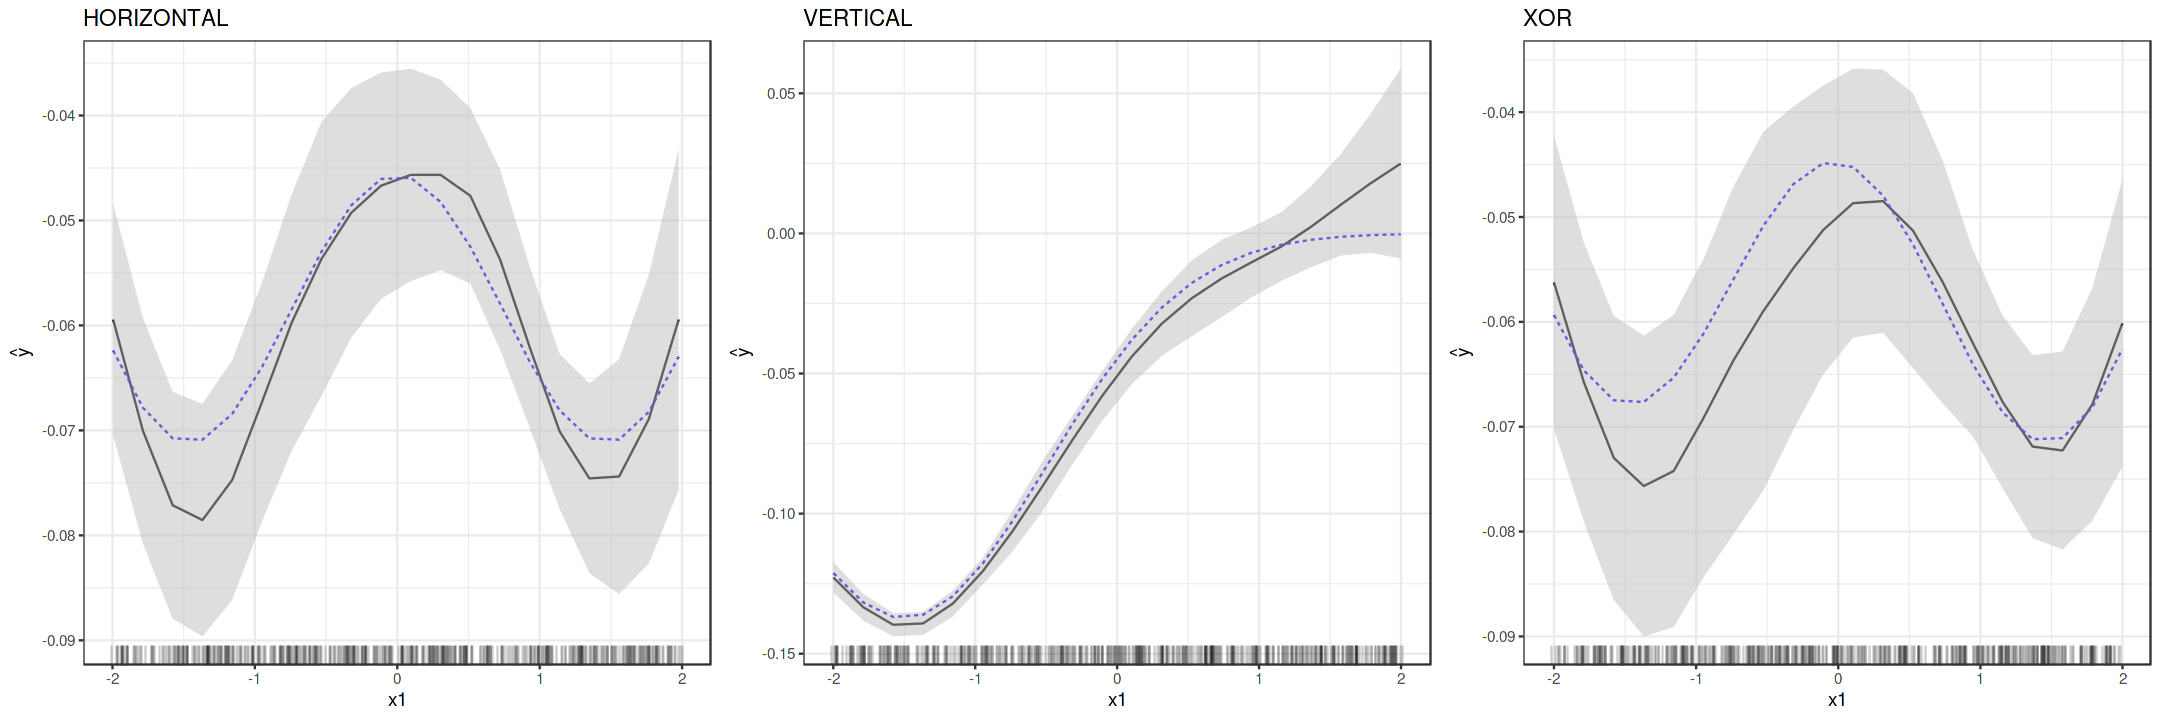

In [211]:
options(repr.plot.width=18, repr.plot.height=6)

grid.arrange(p3, p2, p1, ncol = 3)

## Conditional Partial Dependence Plots

In [235]:
generateConditionalPDP = function(runtype, feature) {
    
    ps = getParamSet(obj[[runtype]])
    train_data_tree = generateDesign(n = 10000, par.set = ps, fun = lhs::randomLHS)
    features = names(train_data_tree)
    
    feature_split = features[-which(feature %in% features)]
    
    model = models[[runtype]]

    pred = predict(model, newdata = train_data_tree)

    train_data_tree$response = pred$data$response
    train_data_tree$se = pred$data$se
    
    lrn_tree = makeLearner("regr.rpart", par.vals = list(maxdepth = 1))
    task = makeRegrTask(data = train_data_tree[, c(feature_split, "se")], target = "se")
    mod = train(lrn_tree, task) 
    splits = mod$learner.model$splits
    
    # create the parameter sets
    psl = lapply(seq_len(nrow(splits)), function(i) {
        id = rownames(splits)[i]
        ps1 = makeParamSet(makeNumericVectorParam("x", len = 2, lower = c(-2, splits[i, "index"]), upper = c(2, 2)))
        ps2 = makeParamSet(makeNumericVectorParam("x", len = 2, lower = c(-2, -2), upper = c(2, splits[i, "index"])))

        ps1 = makeParamSet(makeNumericVectorParam("x", len = 2, lower = c(-2, 0), upper = c(2, 2)))
        ps2 = makeParamSet(makeNumericVectorParam("x", len = 2, lower = c(-2, -2), upper = c(2, 0)))
        
        return(list(ps1, ps2))
    })
    
    # compute PDP's for each of the subsets 
    objs = lapply(psl[[1]], function(ps) {
        objl = obj[[runtype]]
        attr(objl, "par.set") = ps
        objl
    })
    
    pdps = lapply(objs, function(x) {
        plotPDP(x, models[[runtype]], runtype, feature, gt = TRUE, se = TRUE) + theme_bw()
    })
    
    return(list(pdps, psl))
}

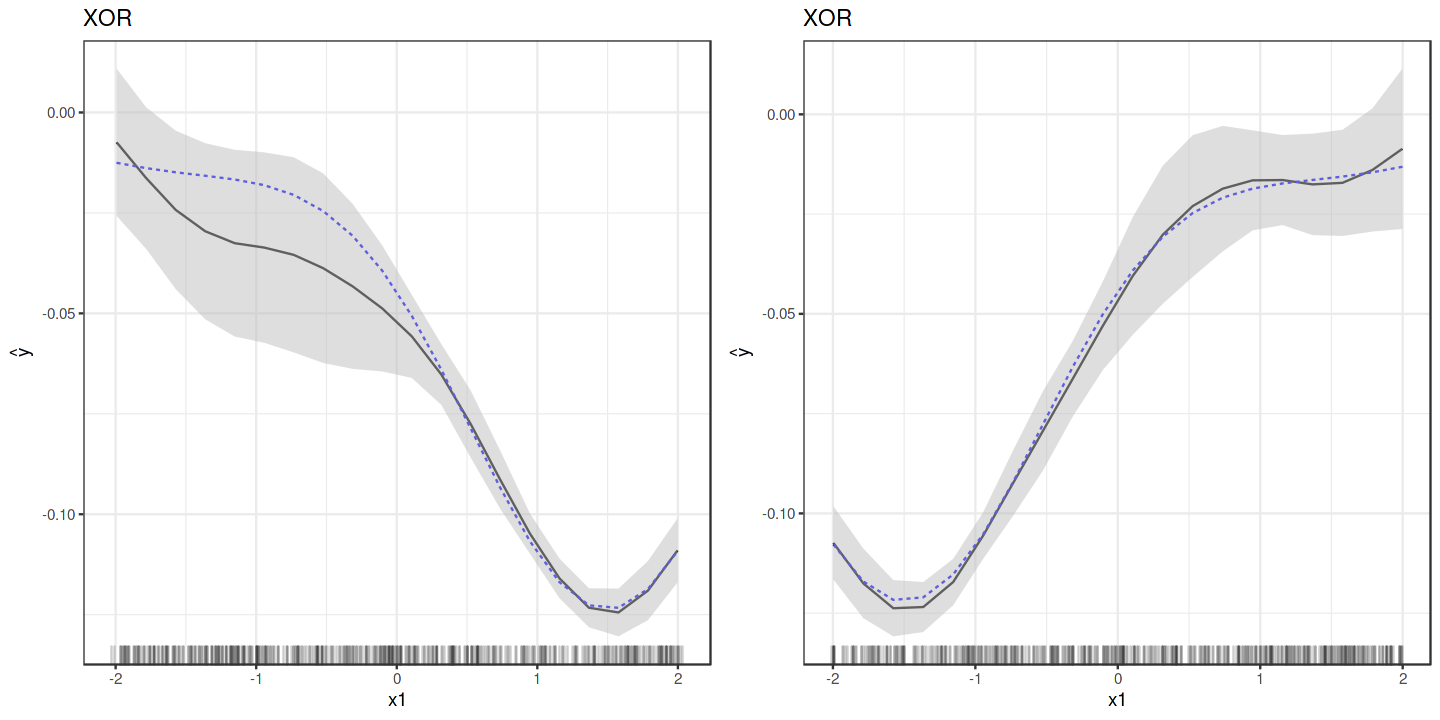

In [237]:
options(repr.plot.width=12, repr.plot.height=6)

pl = generateConditionalPDP("XOR", "x1")

do.call("grid.arrange", c(pl[[1]], ncol = 2))

In [238]:
pl[[2]]

[[1]]
[[1]][[1]]
           Type len Def      Constr Req Tunable Trafo
x numericvector   2   - -2,0 to 2,2   -    TRUE     -

[[1]][[2]]
           Type len Def       Constr Req Tunable Trafo
x numericvector   2   - -2,-2 to 2,0   -    TRUE     -



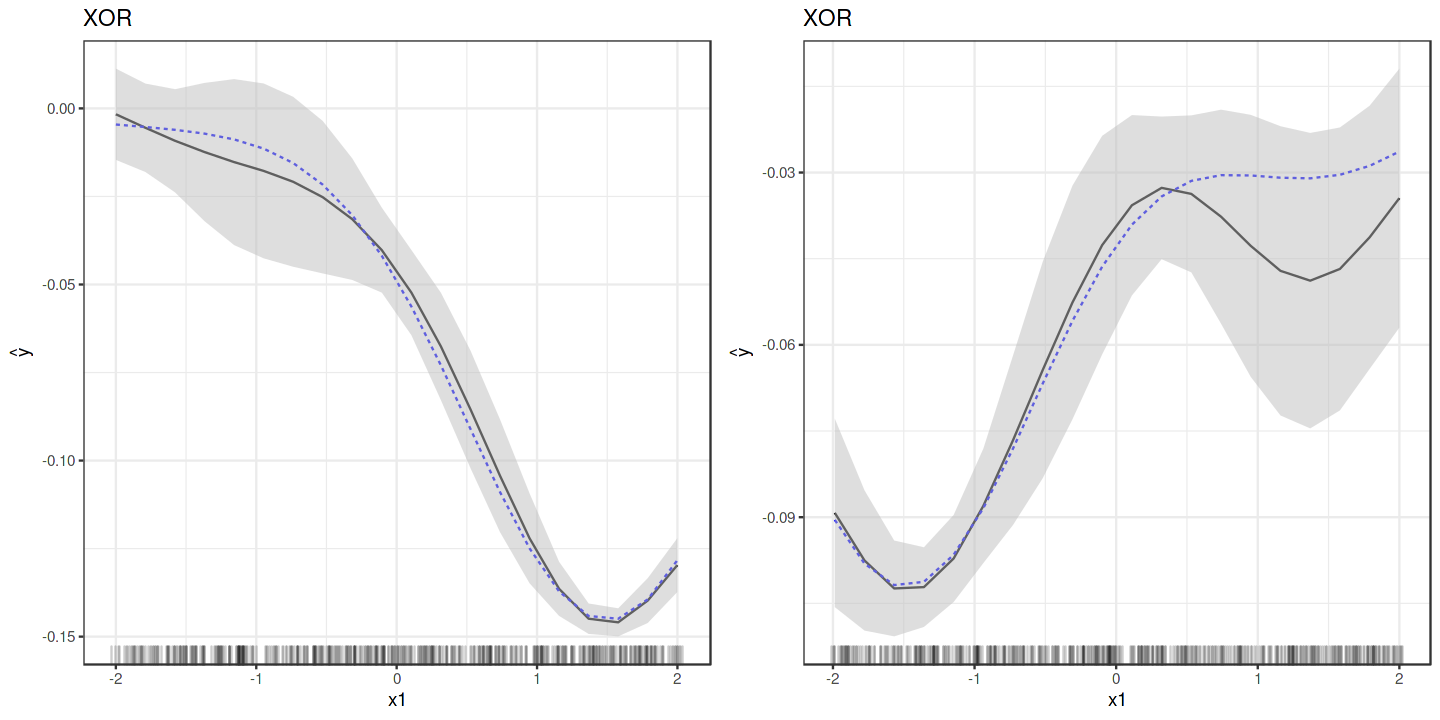

In [20]:
pl = generateConditionalPDP("XOR", "x1")

do.call("grid.arrange", c(pl, ncol = 2))

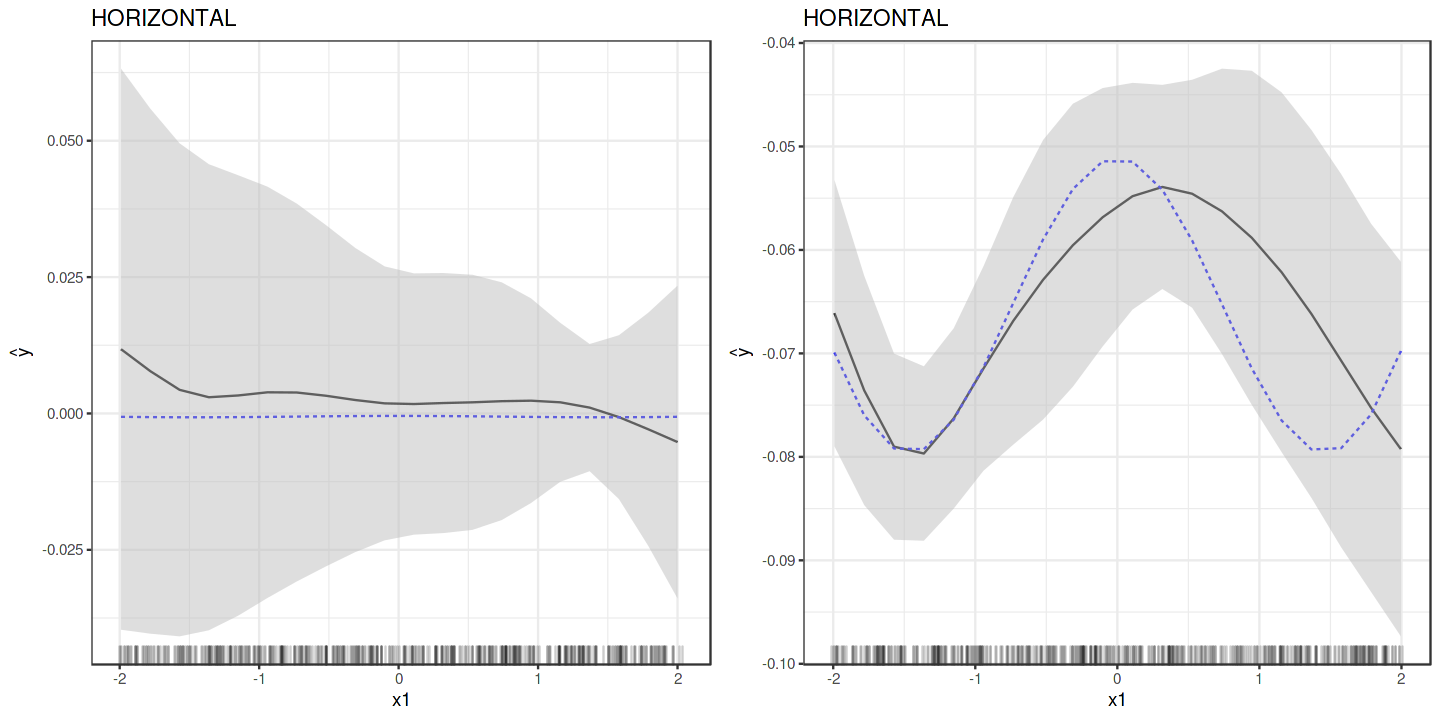

In [21]:
pl = generateConditionalPDP("HORIZONTAL", "x1")

do.call("grid.arrange", c(pl, ncol = 2))

## Thompson Sampling

In [304]:
# create a grid

ps = getParamSet(obj[["HORIZONTAL"]])

x1 <- seq(from = ps$pars$x$lower[1], to = ps$pars$x$upper[1], length.out = 50)
x2 <- seq(from = ps$pars$x$lower[2], to = ps$pars$x$upper[2], length.out = 50)
gg <- expand.grid(x1 = x1, x2 = x2)

In [305]:
samples = DiceKriging::simulate(object = models[["HORIZONTAL"]]$learner.model, newdata = gg, nsim = 500, cond = TRUE)

In [306]:
samples = as.data.frame(t(samples))

In [307]:
gg = cbind(gg, samples)

In [308]:
gg2 = reshape2::melt(data = gg, id.vars = c("x1", "x2"))

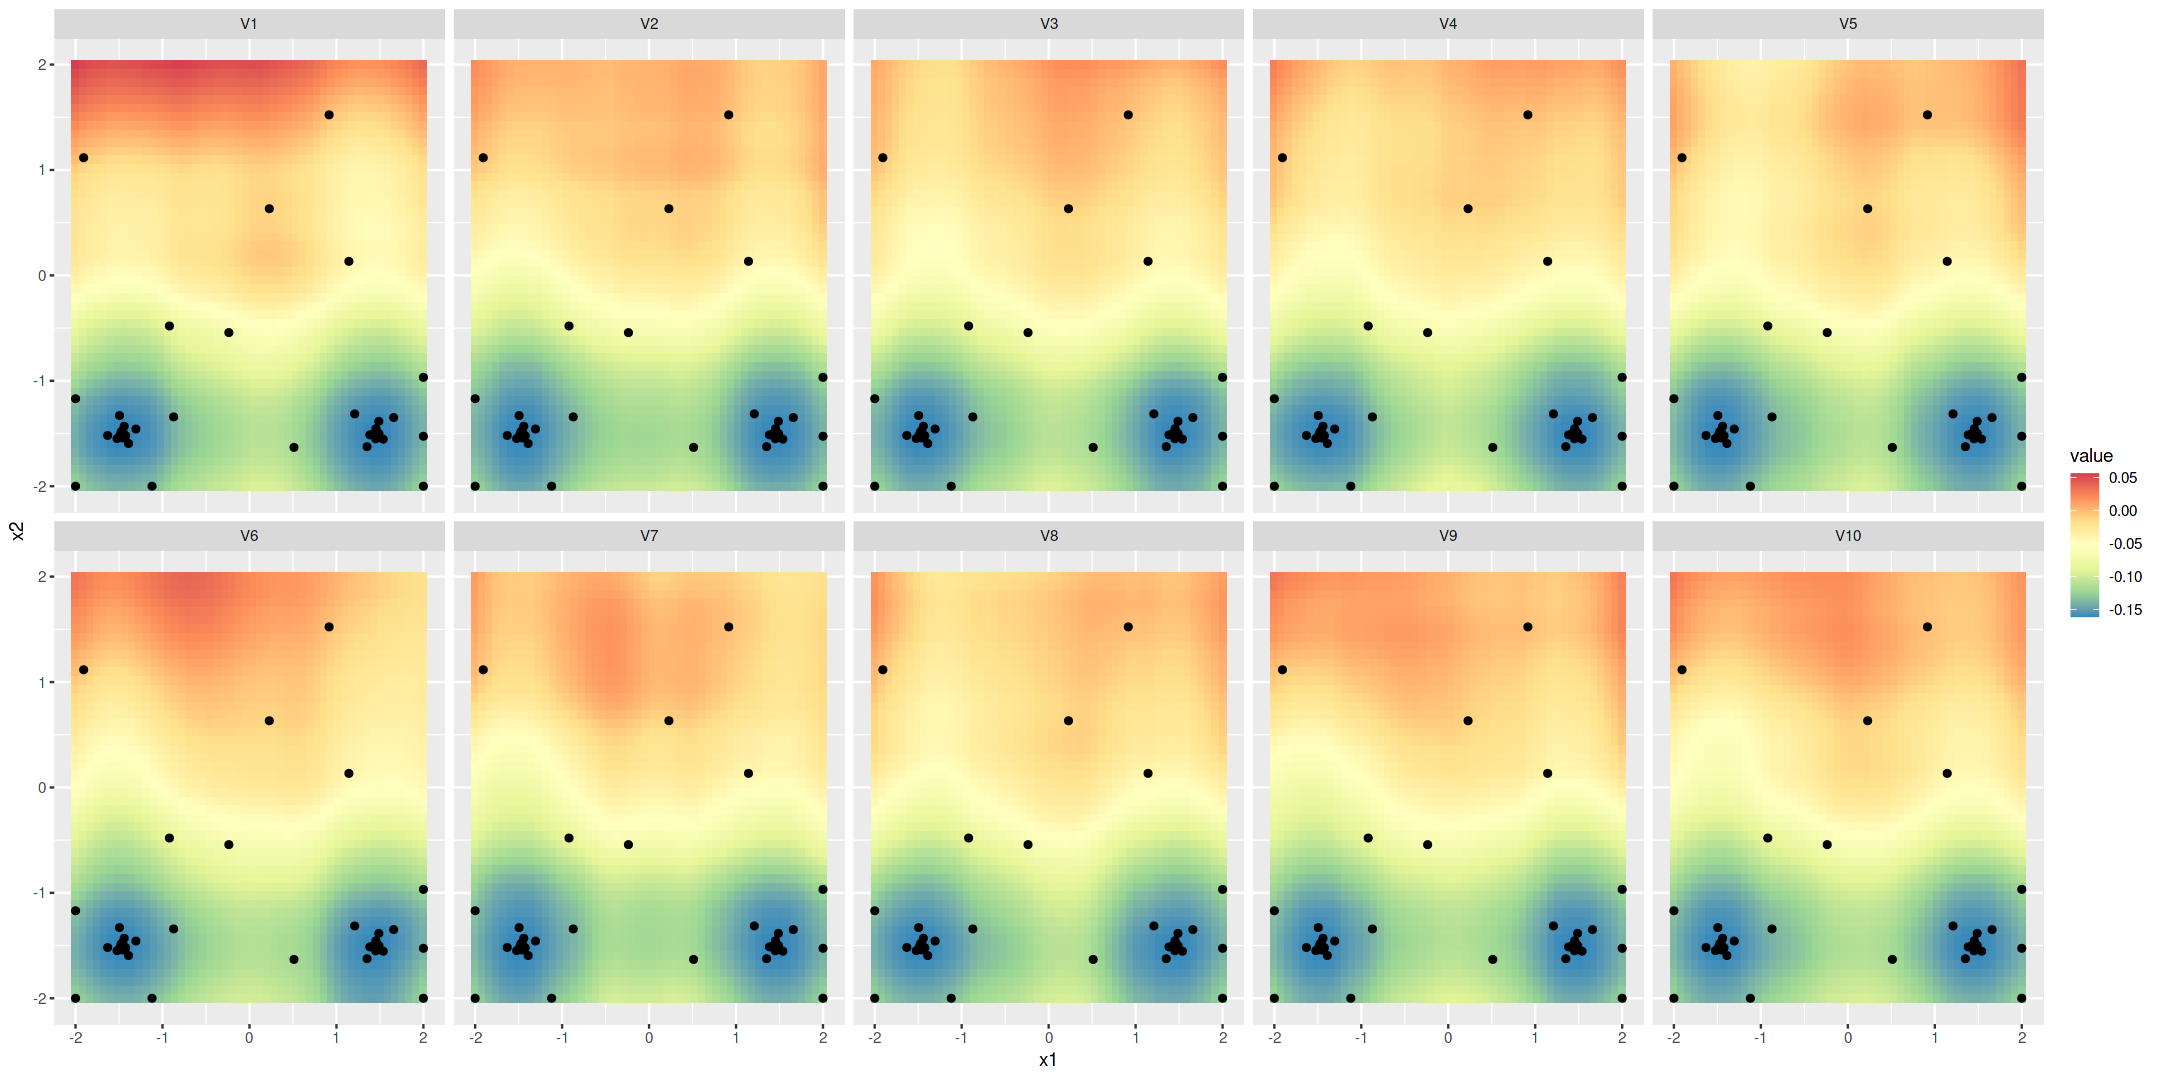

In [309]:
options(repr.plot.width=18, repr.plot.height=9)

p2 = ggplot() + geom_tile(data = gg2[gg2$variable %in% paste("V", 1:10, sep = ""), ], aes(x = x1, y = x2, fill = value))
p2 = p2 + geom_point(data = opdf[type == "HORIZONTAL", ], aes(x = x1, y = x2)) 
p2 = p2 + scale_fill_distiller(palette = "Spectral")

p2 + facet_wrap(. ~ variable, nrow = 2)

In [310]:
# create a Thompson-sampled PDP 

df = as.data.table(gg2)
df = df[, mean(value), by = c("x1")]

In [311]:
p = ggplot(data = df, aes(x = x1, y = V1)) + geom_line() + theme_bw()

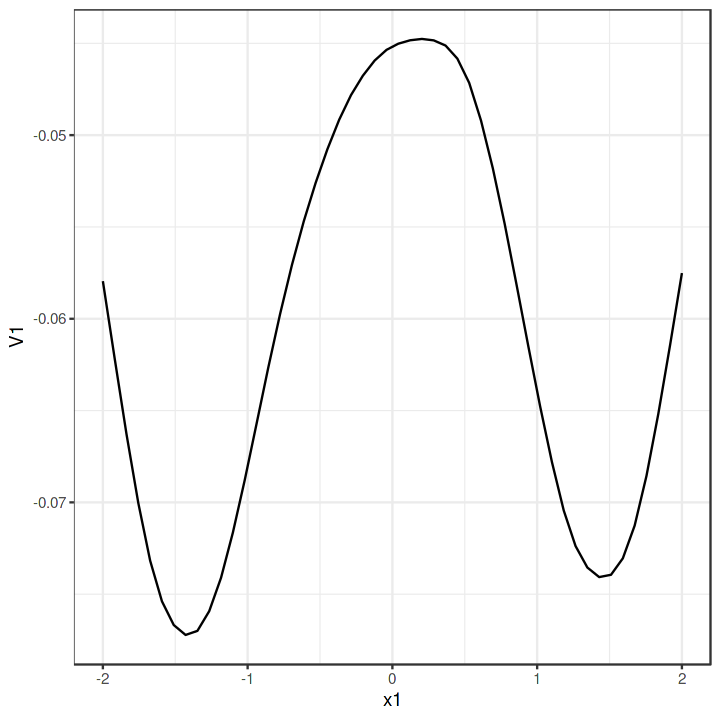

In [312]:
options(repr.plot.width=6, repr.plot.height=6)

p

In [313]:
# Generate a PDP the "usual" way
p1 = plotPDP(obj[["HORIZONTAL"]], models[["HORIZONTAL"]], runtype = "HORIZONTAL", "x1", gt = TRUE, se = TRUE) + theme_bw()
p1 = p1 + geom_line(data = df, aes(x = x1, y = V1), colour = "green")

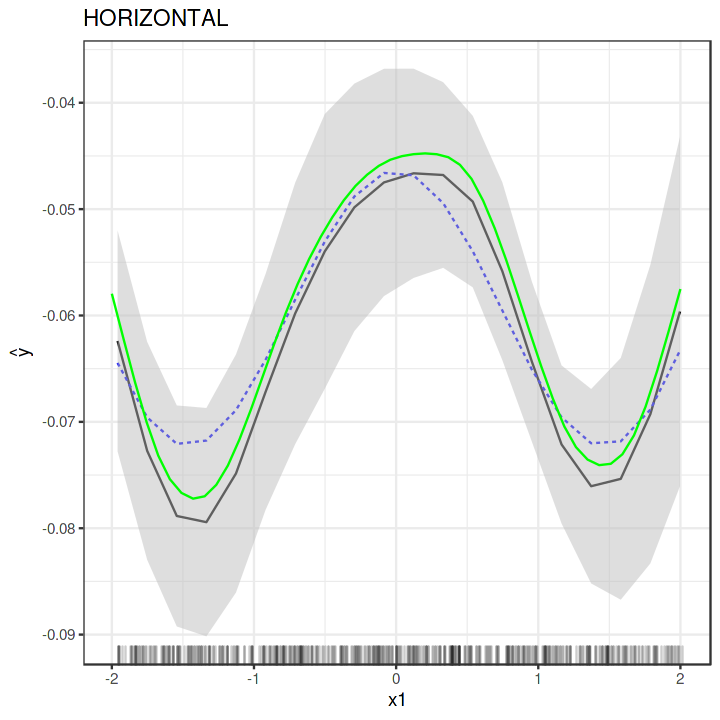

In [314]:
p1

In [152]:
# create a grid

ps = getParamSet(obj[["VERTICAL"]])

x1 <- seq(from = ps$pars$x$lower[1], to = ps$pars$x$upper[1], length.out = 50)
x2 <- seq(from = ps$pars$x$lower[2], to = ps$pars$x$upper[2], length.out = 50)
gg <- expand.grid(x1 = x1, x2 = x2)

In [165]:
pred = predict(object = models[["VERTICAL"]]$learner.model, newdata = gg, type = "SK", se.compute = TRUE, cov.compute = TRUE)

In [166]:
pred$cov[1, 1]

[1] 5.240555e-10

In [167]:
pred$sd[1]^2

[1] 5.240555e-10